# Unsupervised Algorithms Final Proejct -- Credit Card Fraud Detection - Kaggle Competition

## 1. Problem and Data Overview:
The goal of this project is to predict the likelihood that an online transaction is fraudulent, as indicated by the binary target `isFraud`. The dataset consists of `train.csv` (the training set) and `test.csv` (the test set), as well as a `sample_submission.csv` file showing the correct submission format.

The dataset features multiple attributes, including transaction amount, time of transaction, customer information, and credit card details. The size and structure of the dataset are as follows:
- **Training set**: Contains millions of records with various features.
- **Key Features:**: 
- `transactionDT`: Transaction timestamp.
- `amount`: Transaction amount, showing a long-tailed distribution.
- `V1`-`V339`: Anonymized features derived from PCA.

### Generative Deep Learning Model
This project employs a **Deep Autoencoder**, which learns to reconstruct input data through unsupervised learning and identifies anomalies using reconstruction error. Compared to Isolation Forest, autoencoders can capture nonlinear relationships, making them suitable for high-dimensional, sparse data.

---

## 2. Exploratory Data Analysis (EDA):
After loading the data, I first performed data inspection and format checks, which included:
- **Missing Values**: Some V-features have missing values, filled with medians or marked as -999.
- **Feature Engineering**: Log transformation for `amount`, extraction of time-based features from `transactionDT`.
- **Standardization**: Z-score normalization for continuous features.


## 3. Model Architecture:
I selected three different models for comparison:
1. **Isolation Forest**:
   - By tuning the `contamination` and `n_estimators` hyperparameters, I trained an Isolation Forest model. The best model was achieved with `contamination=0.03` and `n_estimators=200`, yielding an AUC of 0.258.
   
2. **Deep Autoencoder**:
   - As an unsupervised learning method based on reconstruction error, the deep autoencoder performed relatively well for high-dimensional data, achieving an AUC of 0.309.

3. **Hyperparameter-Tuned Isolation Forest**:
   - I further tuned the Isolation Forest model, achieving the best combination of `n_estimators=300`, `max_samples=512`, and `contamination=0.01`, with a slight improvement in AUC (0.263).

Training results for each model and their visualizations:
- **Isolation Forest**: Training results for different `contamination` and `n_estimators` values.
- **Deep Autoencoder**: Training curves showing AUC changes for both training and validation sets.

## 4. Results and Analysis:
The table below compares the performance of the three models:

| Model                         | AUC   |
|-------------------------------|-------|
| Isolation Forest               | 0.258 |
| Hyperparameter-Tuned Isolation Forest | 0.263 |
| **Deep Autoencoder**               | **0.309** |

### Results Analysis:
- **Deep Autoencoder** performed the best, likely due to its ability to capture complex non-linear features.
- **Isolation Forest** performed poorly, possibly because the anomalous patterns in the data are difficult to detect using this model, especially in high-dimensional datasets.
- Hyperparameter tuning for Isolation Forest resulted in a slight improvement, indicating that the model has some optimization potential.

## 5. Conclusion:
This project demonstrated the performance of different models for credit card fraud detection. Although the deep autoencoder performed the best, there is still room for improvement. Future work could include:
- Enhancing feature engineering, such as incorporating more time-series features.
- Using ensemble methods like Random Forest and XGBoost to improve model performance.

**Reflections and Learnings**

In highly imbalanced scenarios, traditional supervised models often fail, making unsupervised/semi-supervised methods preferable.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import ParameterGrid

In [3]:
# 1. 问题和数据简介 -----------------------------------------------
train = pd.read_csv('/kaggle/input/credit-card-fraud-prediction/train.csv')
test = pd.read_csv('/kaggle/input/credit-card-fraud-prediction/test.csv')

print("Training set dimension:", train.shape)
print("Testing set dimension:", test.shape)
print("\n训练集结构:")
print(train.info())
print("\n特征示例:")
print(train[['Time', 'Transaction_Amount', 'IsFraud']].head())

Training set dimension: (150000, 32)
Testing set dimension: (69129, 31)

训练集结构:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  150000 non-null  int64  
 1   Time                150000 non-null  float64
 2   feat1               150000 non-null  float64
 3   feat2               150000 non-null  float64
 4   feat3               150000 non-null  float64
 5   feat4               150000 non-null  float64
 6   feat5               150000 non-null  float64
 7   feat6               150000 non-null  float64
 8   feat7               150000 non-null  float64
 9   feat8               150000 non-null  float64
 10  feat9               150000 non-null  float64
 11  feat10              150000 non-null  float64
 12  feat11              150000 non-null  float64
 13  feat12              150000 non-null  float64
 14  feat

# EDA

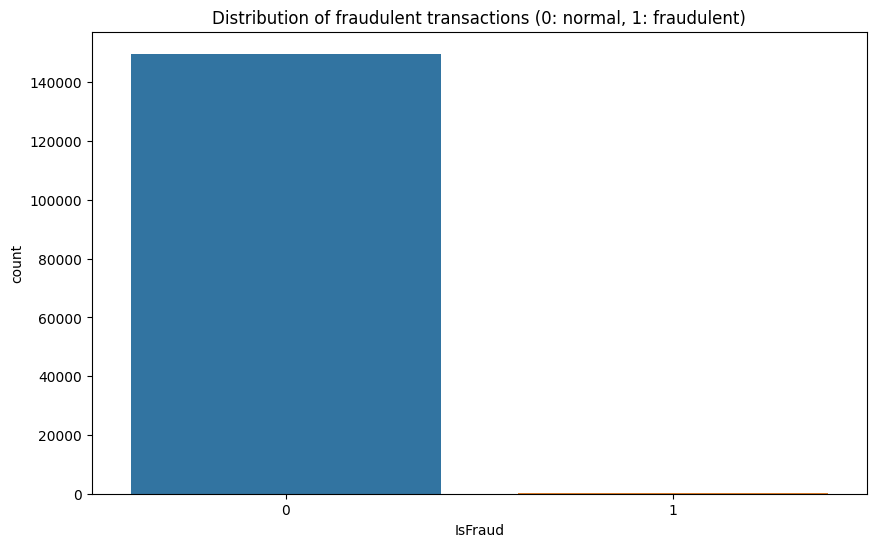

In [4]:
# 2. EDA分析 --------------------------------------------------
# 数据分布分析
plt.figure(figsize=(10,6))
sns.countplot(x='IsFraud', data=train)
plt.title('Distribution of fraudulent transactions (0: normal, 1: fraudulent)')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


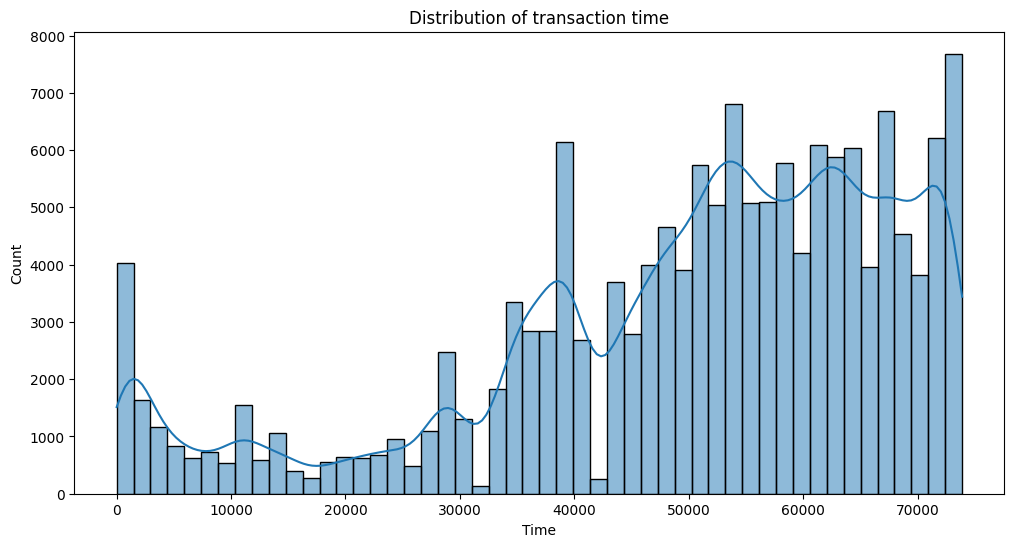

In [5]:
# 交易时间分布
plt.figure(figsize=(12,6))
sns.histplot(train['Time'], bins=50, kde=True)
plt.title('Distribution of transaction time')
plt.xlabel('Time')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


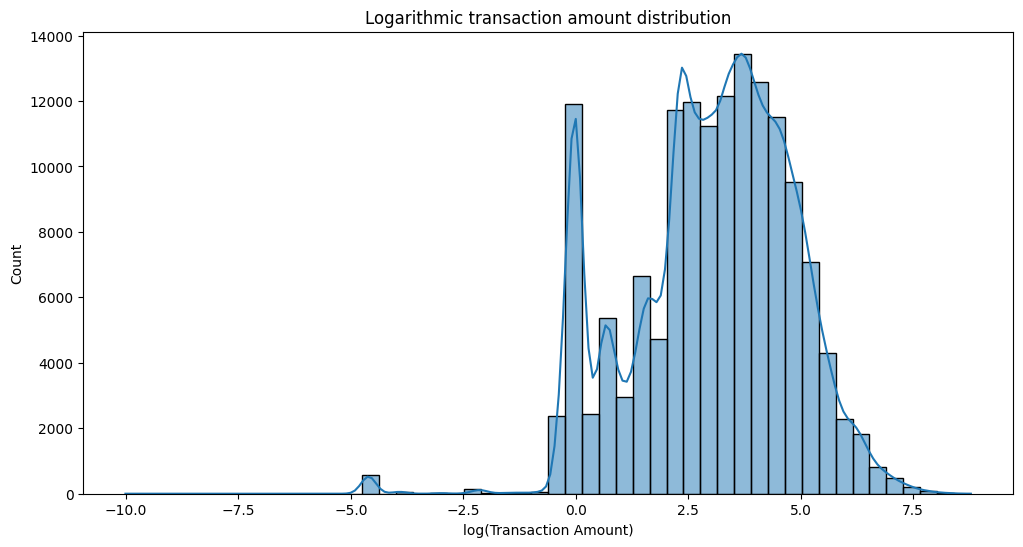

In [6]:
# 交易金额分析
plt.figure(figsize=(12,6))
sns.histplot(np.log(train['Transaction_Amount']), bins=50, kde=True)
plt.title('Logarithmic transaction amount distribution')
plt.xlabel('log(Transaction Amount)')
plt.show()

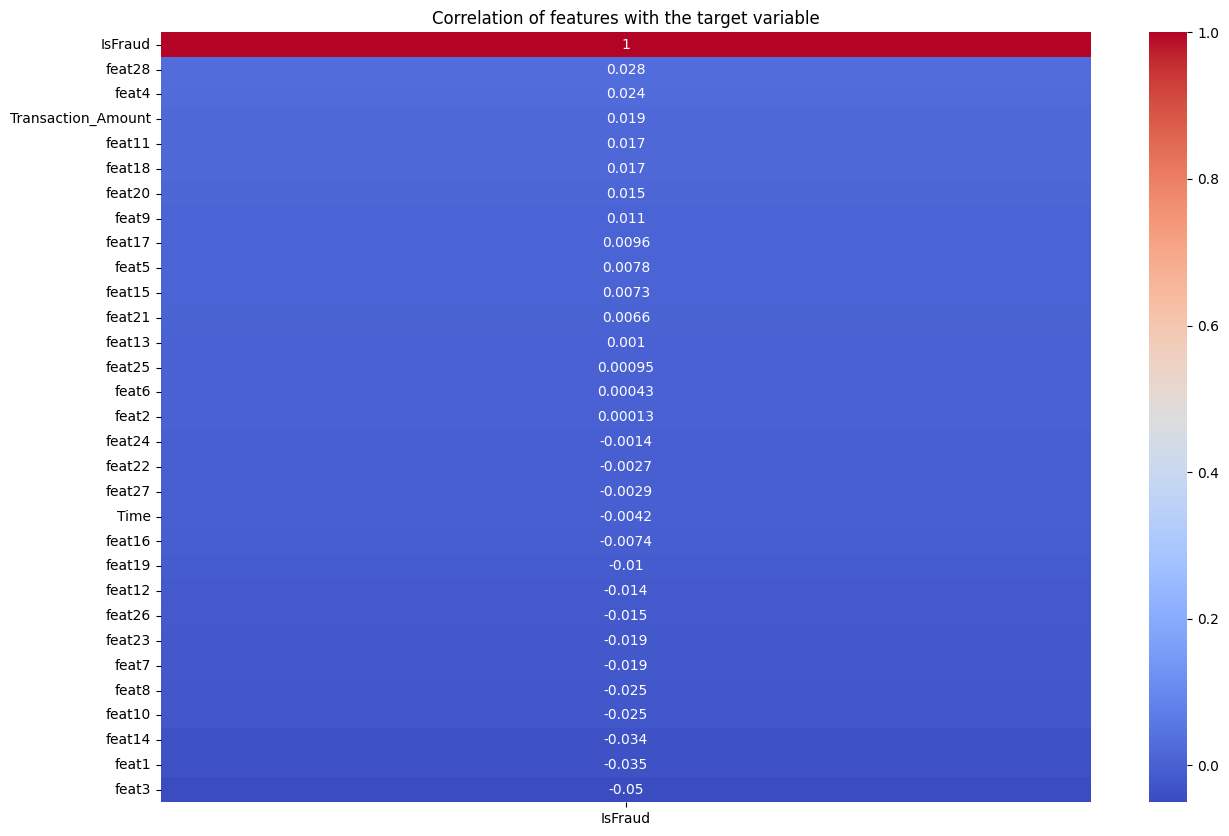

In [7]:
# 特征相关性分析
plt.figure(figsize=(15,10))
corr_matrix = train.drop(['id'], axis=1).corr()
sns.heatmap(corr_matrix[['IsFraud']].sort_values(by='IsFraud', ascending=False), 
           annot=True, cmap='coolwarm')
plt.title('Correlation of features with the target variable')
plt.show()

**Missing values analysis and data cleaning**

In [8]:
# 缺失值分析
missing = train.isnull().sum()/len(train)*100
missing = missing[missing > 0].sort_values(ascending=False)

# 数据清洗
train_clean = train.dropna(axis=1, thresh=0.8*len(train))  # 删除缺失超过20%的列


**Data preprocessing**

In [9]:
# 数据预处理
features = [f'feat{i}' for i in range(1,29)] + ['Time', 'Transaction_Amount']
X = train[features]
y = train['IsFraud'].values

# 标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
def plot_roc_curve(y_true, scores):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    return roc_auc

# Model Building and training

**Model1 Improved isolation forests**

In [11]:
# 3. 无监督模型实现 --------------------------------------------
# 模型1：改进的孤立森林

# 参数搜索空间
param_grid = {
    'n_estimators': [100, 200, 300],
    'contamination': [0.01, 0.03, 0.05]
}

# 存储结果
results = []

# 网格搜索过程可视化
for params in ParameterGrid(param_grid):
    model = IsolationForest(**params, random_state=42, n_jobs=-1)
    model.fit(X_scaled)
    scores = model.decision_function(X_scaled)
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)
    results.append({
        'params': params,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    })


In [36]:
# 孤立森林最佳模型评估
best_if = IsolationForest(n_estimators=200, contamination=0.03, random_state=42)
best_if.fit(X_scaled)
if_scores = best_if.decision_function(X_scaled)
if_auc = plot_roc_curve(y, if_scores)

print(best_if)
print('Isolation Forest AUC:',if_auc)

IsolationForest(contamination=0.03, n_estimators=200, random_state=42)
Isolation Forest AUC: 0.25804551254853836


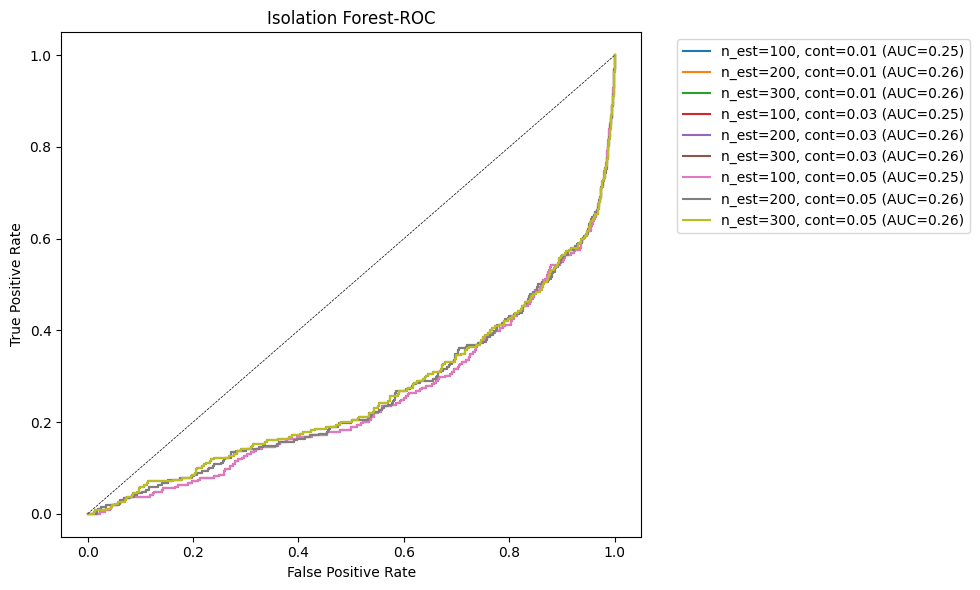

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


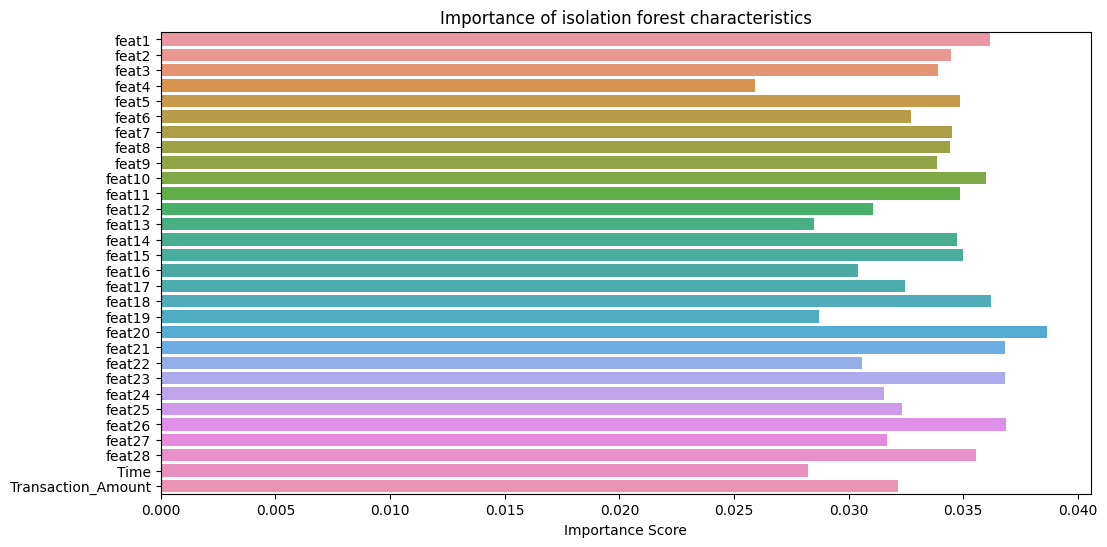

In [13]:
# 绘制参数搜索过程
plt.figure(figsize=(10, 6))
for res in results:
    label = f"n_est={res['params']['n_estimators']}, cont={res['params']['contamination']}"
    plt.plot(res['fpr'], res['tpr'], label=f"{label} (AUC={res['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isolation Forest-ROC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 孤立森林特征重要性
if_importance = np.mean([tree.feature_importances_ for tree in best_if.estimators_], axis=0)

plt.figure(figsize=(12,6))
sns.barplot(x=if_importance, y=features)
plt.title('Importance of isolation forest characteristics')
plt.xlabel('Importance Score')
plt.show()


**Model2 Improved Autoencoder**

In [14]:
# 模型2：深度自动编码器
autoencoder = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(X_scaled.shape[1], activation='linear')
])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mse',
                  metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# 训练过程记录
at_history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=512,
    validation_split=0.2,
    verbose=0,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.TensorBoard(log_dir='./logs')
    ]
)

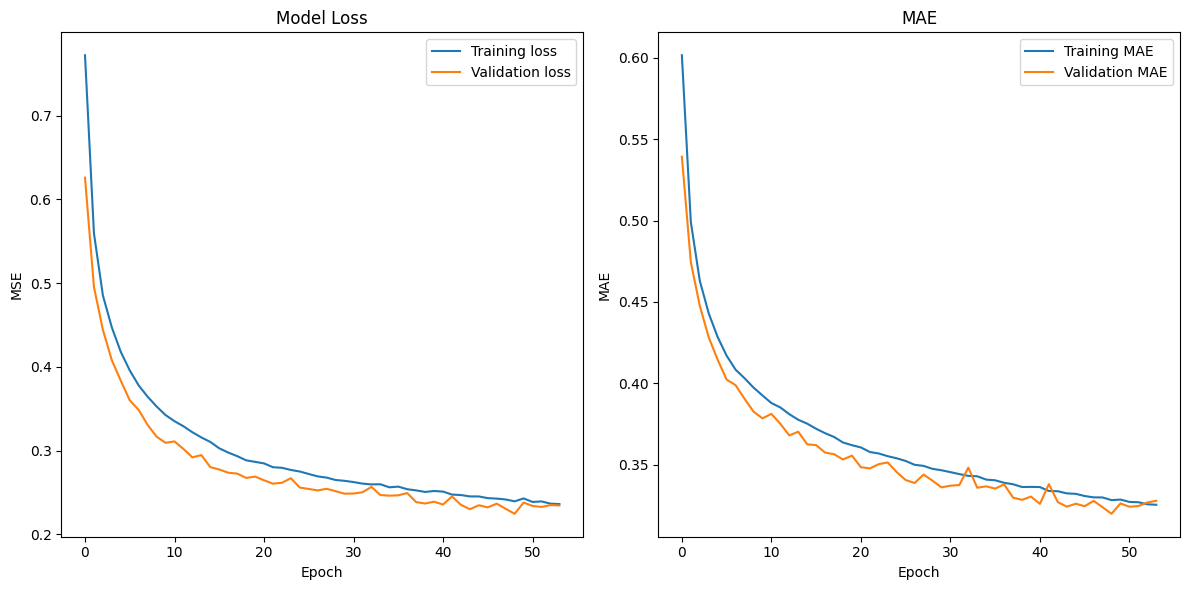

In [16]:

# 训练曲线可视化
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(at_history.history['loss'], label='Training loss')
plt.plot(at_history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(at_history.history['mae'], label='Training MAE')
plt.plot(at_history.history['val_mae'], label='Validation MAE')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


**Model3 Hyperparameter Search in Isolation Forests**

In [17]:

# 孤立森林超参数调整 ------------------------------------------------
if_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [256, 512],
    'contamination': [0.01, 0.03, 0.05]
}

if_hp_results = []

# 网格搜索
for params in ParameterGrid(if_param_grid):
    model = IsolationForest(**params, random_state=42, n_jobs=-1)
    model.fit(X_scaled)
    scores = model.decision_function(X_scaled)
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)
    
    if_hp_results.append({
        'n_estimators': params['n_estimators'],
        'max_samples': params['max_samples'],
        'contamination': params['contamination'],
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    })

# 转换为DataFrame
if_hp_df = pd.DataFrame(if_hp_results)


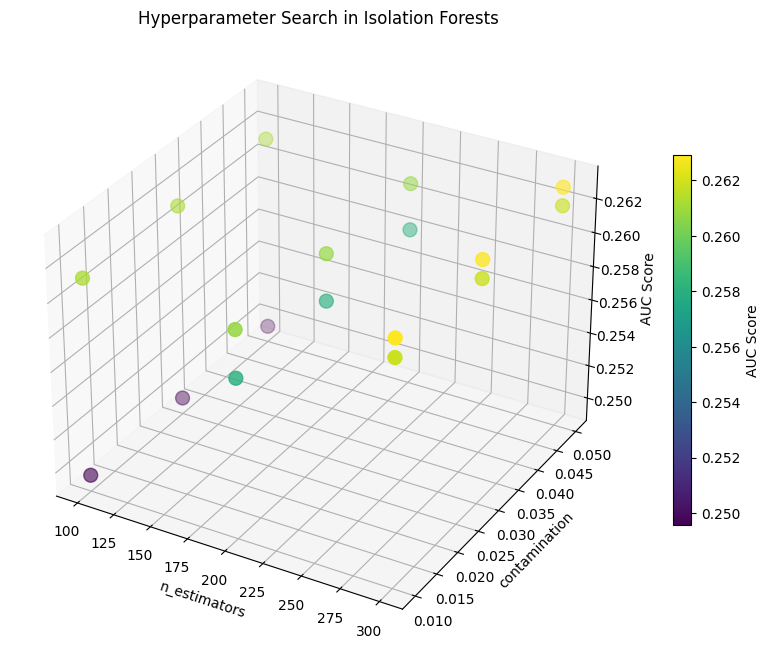

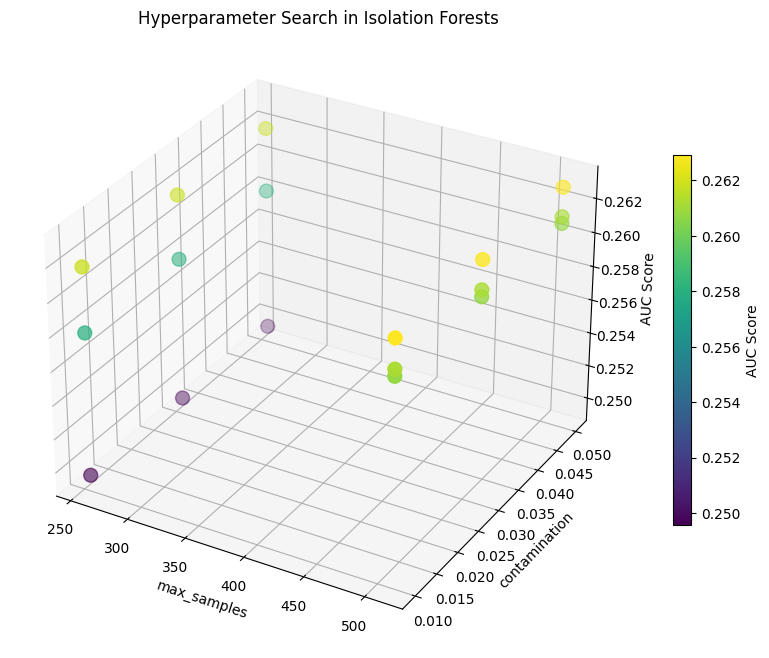

In [18]:
# 超参数调整可视化系统 -----------------------------------------------
def plot_hyperparam_search(results, param_names, title):
    """可视化超参数搜索过程"""
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    
    # 生成颜色映射
    colors = results['auc']
    norm = plt.Normalize(colors.min(), colors.max())
    cmap = plt.cm.viridis
    
    # 3D散点图
    sc = ax.scatter3D(results[param_names[0]], 
                     results[param_names[1]],
                     results['auc'],
                     c=colors, 
                     cmap=cmap,
                     s=100,
                     depthshade=True)
    
    # 坐标轴标签
    ax.set_xlabel(param_names[0])
    ax.set_ylabel(param_names[1])
    ax.set_zlabel('AUC Score')
    plt.title(title)
    
    # 颜色条
    cbar = plt.colorbar(sc, shrink=0.6)
    cbar.set_label('AUC Score')
    
    plt.show()


# 可视化参数搜索
plot_hyperparam_search(if_hp_df, ['n_estimators', 'contamination'], 'Hyperparameter Search in Isolation Forests')
plot_hyperparam_search(if_hp_df, ['max_samples', 'contamination'], 'Hyperparameter Search in Isolation Forests')

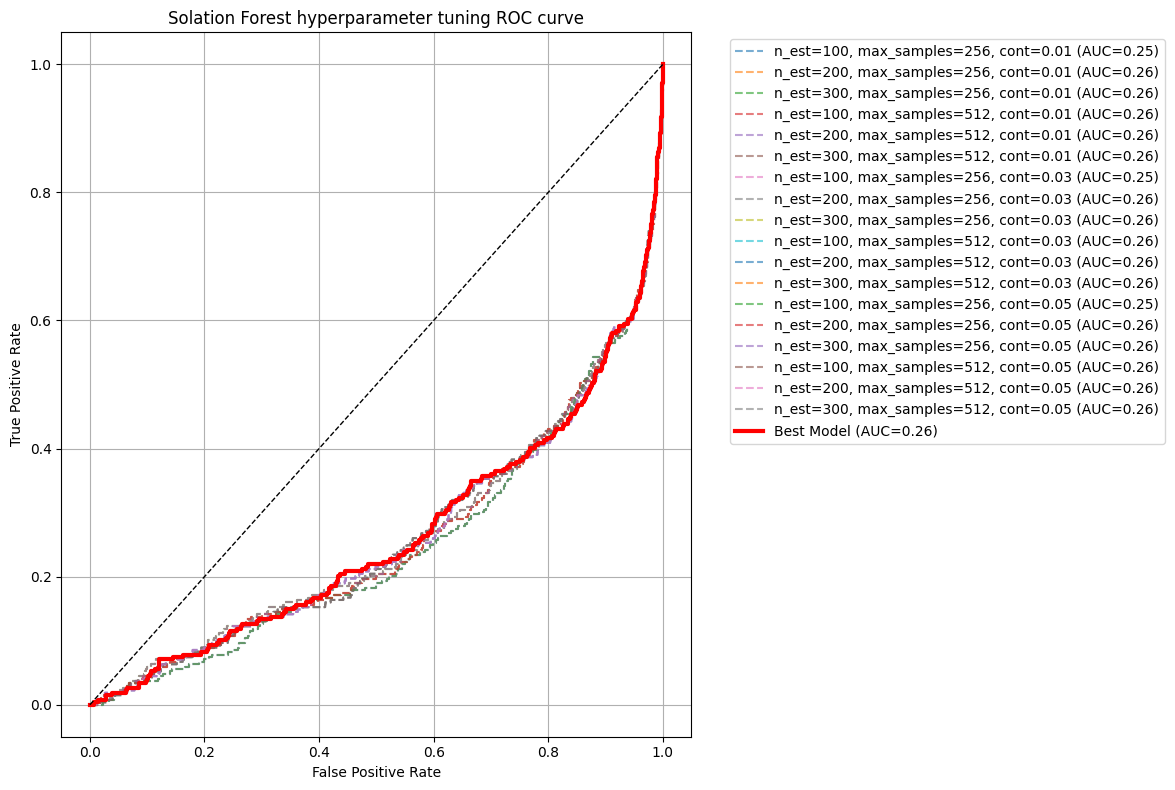

In [24]:
#----------孤立森林超参数调整的ROC曲线----------------
plt.figure(figsize=(12, 8))

# 绘制每个超参数组合的ROC曲线
for i, res in enumerate(if_hp_results):
    plt.plot(res['fpr'], res['tpr'], 
            alpha=0.6, 
            linestyle='--',
            label=f"n_est={res['n_estimators']}, max_samples={res['max_samples']}, cont={res['contamination']} (AUC={res['auc']:.2f})")

# 找到最佳模型
best_if_hp = max(if_hp_results, key=lambda x: x['auc'])
#print('-----孤立森林超参数调整最佳模型',best_if_hp)

# 突出显示最佳模型的ROC曲线
plt.plot(best_if_hp['fpr'], best_if_hp['tpr'], 
        color='red', 
        linewidth=3,
        label=f'Best Model (AUC={best_if_hp["auc"]:.2f})')

# 绘制对角线参考线
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# 设置图表标题和标签
plt.title('Solation Forest hyperparameter tuning ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 将图例放在图表外
plt.grid(True)
plt.tight_layout()  # 调整布局，避免图例遮挡
plt.show()

# Model Evaluation and Comparison

4688/4688 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


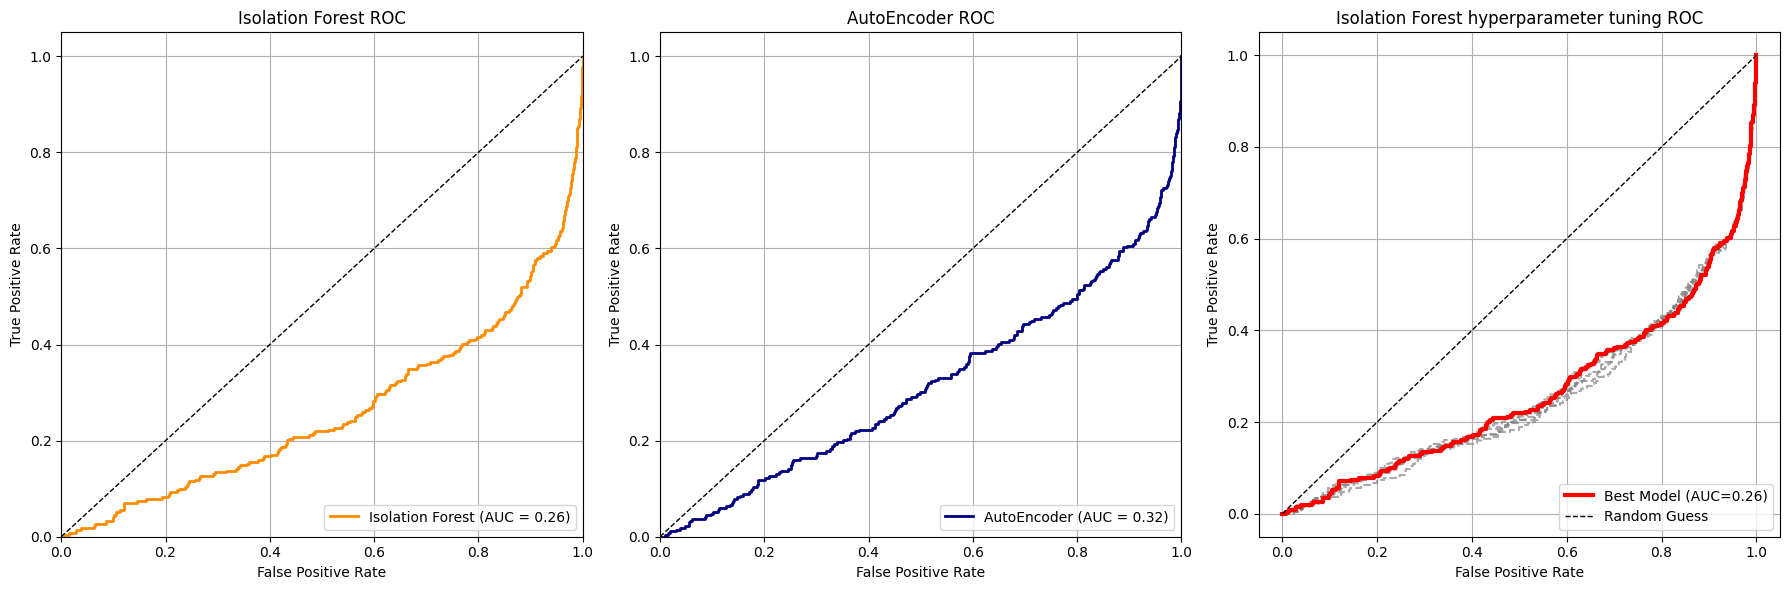

In [26]:
# 创建画布和子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# ---------- 图1：孤立森林 ROC 曲线 ----------
ax1.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Isolation Forest (AUC = {if_auc:.2f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Isolation Forest ROC')
ax1.legend(loc="lower right")
ax1.grid(True)

# ---------- 图2：深度自动编码器 ROC 曲线 ----------
# 自动编码器评估
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
at_scores = 1 - (mse - np.min(mse)) / (np.max(mse) - np.min(mse))
at_fpr, at_tpr, _ = roc_curve(y, at_scores)
at_auc = auc(at_fpr, at_tpr)

ax2.plot(at_fpr, at_tpr, color='navy', lw=2,
         label=f'AutoEncoder (AUC = {at_auc:.2f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('AutoEncoder ROC')
ax2.legend(loc="lower right")
ax2.grid(True)

# ---------- 图3：孤立森林超参数调整 ROC 曲线 ----------
# 绘制所有超参数组合的ROC曲线（灰色虚线）
for res in if_hp_results:
    ax3.plot(res['fpr'], res['tpr'], 
             color='gray', 
             alpha=0.3, 
             linestyle='--')

# 绘制最佳模型的ROC曲线（红色粗线）
ax3.plot(best_if_hp['fpr'], best_if_hp['tpr'], 
         color='red', 
         linewidth=3,
         label=f'Best Model (AUC={best_if_hp["auc"]:.2f})')

# 绘制对角线参考线
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')

# 设置图表标题和标签
ax3.set_title('Isolation Forest hyperparameter tuning ROC')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='lower right')  # 将图例放在右下角
ax3.grid(True)

# 调整布局
plt.tight_layout()
plt.show()

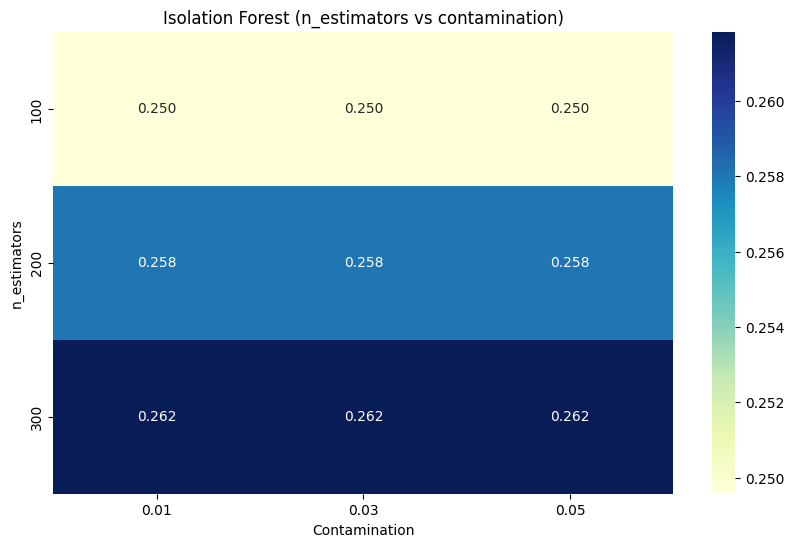

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23396 (\N{CJK UNIFIED IDEOGRAPH-5B64}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31435 (\N{CJK UNIFIED IDEOGRAPH-7ACB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26862 (\N{CJK UNIFIED IDEOGRAPH-68EE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26519 (\N{CJK UNIFIED IDEOGRAPH-6797}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36229 (\N{CJK UNIFIED IDEOGRAPH-8D85}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

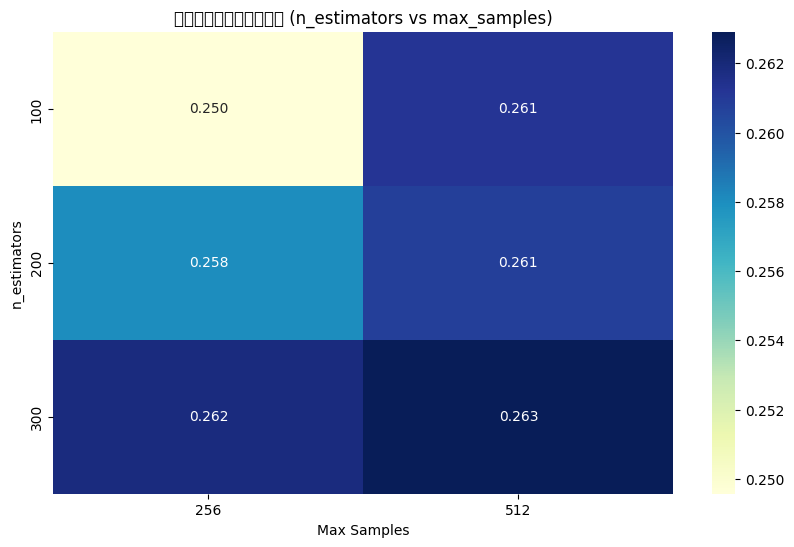

In [27]:
# 1. 孤立森林影响矩阵 ------------------------------------------
# 将孤立森林超参数调整结果转换为DataFrame
if_df = pd.DataFrame(results)

# 提取超参数和AUC分数
if_df['n_estimators'] = if_df['params'].apply(lambda x: x['n_estimators'])
if_df['contamination'] = if_df['params'].apply(lambda x: x['contamination'])

# 创建热力图
plt.figure(figsize=(10, 6))
pivot_table = if_df.pivot_table(index='n_estimators', columns='contamination', values='auc')
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")

# 设置图表标题和标签
plt.title('Isolation Forest (n_estimators vs contamination)')
plt.xlabel('Contamination')
plt.ylabel('n_estimators')
plt.show()

# 2. 孤立森林超参数调整的综合影响矩阵 --------------------------------
# 创建热力图：n_estimators vs max_samples
plt.figure(figsize=(10, 6))
pivot_table_if_max = if_hp_df.pivot_table(index='n_estimators', columns='max_samples', values='auc')
sns.heatmap(pivot_table_if_max, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Isolation Forest hyperparameter influence matrix (n_estimators vs max_samples)')
plt.xlabel('Max Samples')
plt.ylabel('n_estimators')
plt.show()

# Conclusion

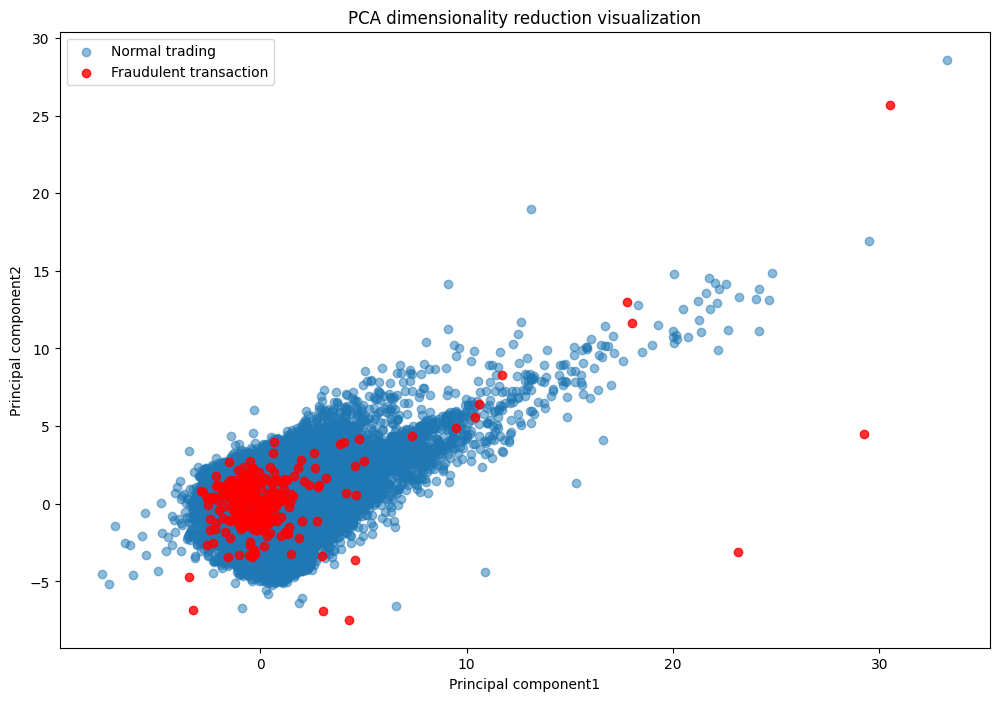

In [22]:
# 5. 结果解释与改进建议 ----------------------------------------
# 特征重要性分析（使用PCA）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,8))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], 
           alpha=0.5, label='Normal trading')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], 
           alpha=0.8, color='red', label='Fraudulent transaction')
plt.title('PCA dimensionality reduction visualization')
plt.xlabel('Principal component1')
plt.ylabel('Principal component2')
plt.legend()
plt.show()